# TELECOM CUSTOMER CHURN PREDICTION PROJECT


## 1)Import Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## 2)Load Dataset


In [5]:
column_names = ["State", "Account Length", "Area Code", "Phone", "International Plan", "VMail Plan", "VMail Message",
                "Day Mins", "Day Calls", "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins",
                "Night Calls", "Night Charge", "International Mins", "International calls", "International Charge",
                "CustServ Calls", "Churn"]
df = pd.read_csv("telecom_churn_data.csv", header=0, names=column_names) # Set header=0 to use the first row as header
print("Data Shape:", df.shape)
df.head()

Data Shape: (4617, 21)


,State,Account Length,Area Code,Phone,International Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,International Mins,International calls,International Charge,CustServ Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


## 3)Data Preprocessing


In [7]:
df.drop(["Phone"], axis=1, inplace=True)

le = LabelEncoder()
df["International Plan"] = le.fit_transform(df["International Plan"])
df["VMail Plan"] = le.fit_transform(df["VMail Plan"])
df["Churn"] = le.fit_transform(df["Churn"])

numeric_cols = ["Account Length", "Area Code", "VMail Message", "Day Mins", "Day Calls",
                "Day Charge", "Eve Mins", "Eve Calls", "Eve Charge", "Night Mins",
                "Night Calls", "Night Charge", "International Mins", "International calls",
                "International Charge", "CustServ Calls"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df.isnull().sum())

df.drop(["Day Charge", "Eve Charge", "Night Charge", "International Charge"], axis=1, inplace=True)

State                   0
Account Length          0
Area Code               0
International Plan      0
VMail Plan              0
VMail Message           0
Day Mins                0
Day Calls               0
Day Charge              0
Eve Mins                0
Eve Calls               0
Eve Charge              0
Night Mins              0
Night Calls             0
Night Charge            0
International Mins      0
International calls     0
International Charge    0
CustServ Calls          0
Churn                   0
dtype: int64


## 4)Exploratory Data Analysis (EDA)


### a)Univariate Analysis (Single Variable)

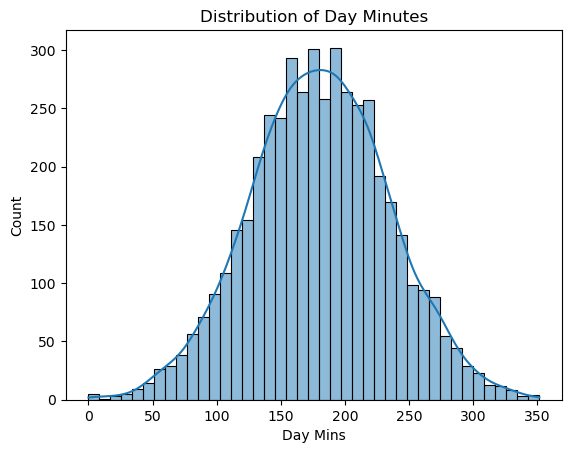

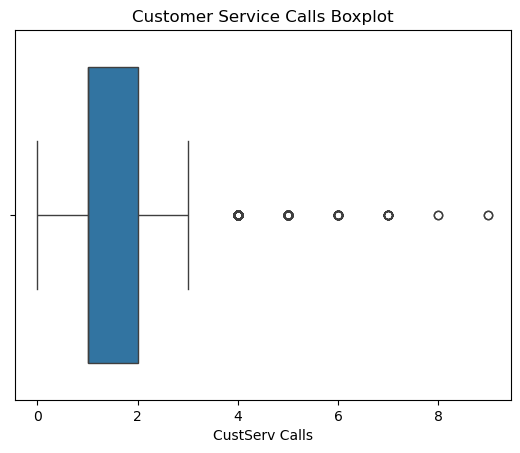

In [10]:
sns.histplot(df['Day Mins'], kde=True)
plt.title("Distribution of Day Minutes")
plt.show()

sns.boxplot(x=df['CustServ Calls'])
plt.title("Customer Service Calls Boxplot")
plt.show()


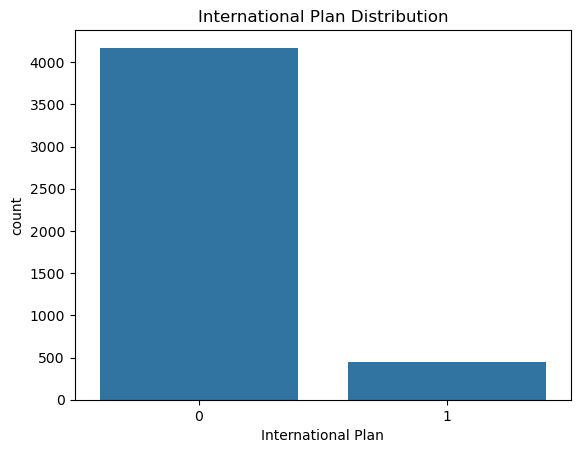

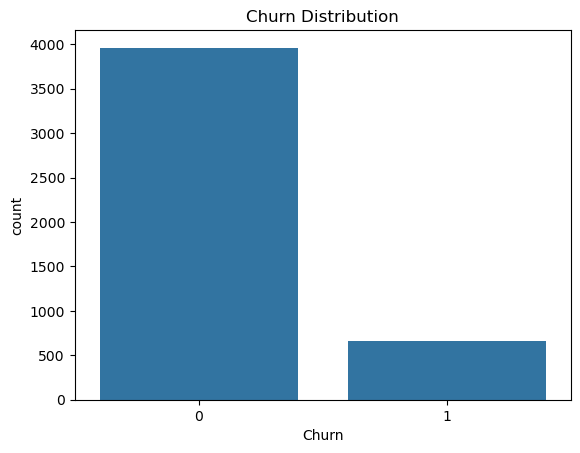

In [11]:
df['International Plan'].value_counts()
sns.countplot(x='International Plan', data=df)
plt.title("International Plan Distribution")
plt.show()

df['Churn'].value_counts()
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()


### B)Bivariate Analysis (Two Variables)

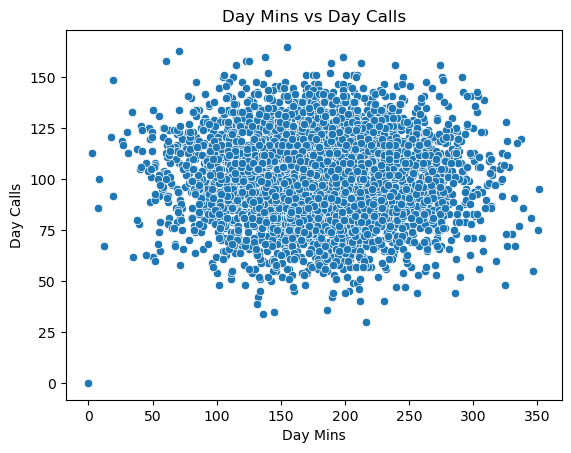

,Day Mins,Day Calls
Day Mins,1.000000,-0.002823
Day Calls,-0.002823,1.000000


In [13]:
sns.scatterplot(x='Day Mins', y='Day Calls', data=df)
plt.title("Day Mins vs Day Calls")
plt.show()

df[['Day Mins', 'Day Calls']].corr()


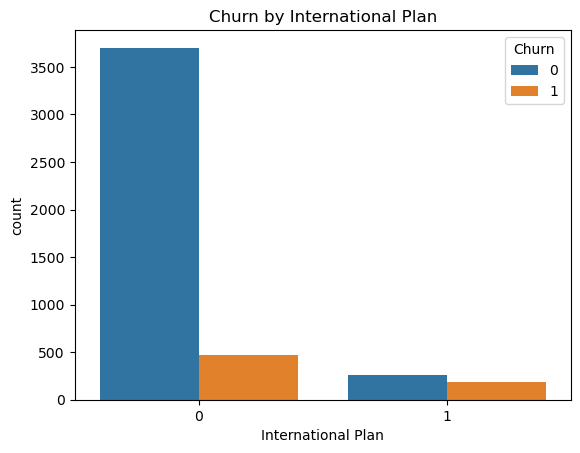

In [14]:
pd.crosstab(df['International Plan'], df['Churn'])

sns.countplot(x='International Plan', hue='Churn', data=df)
plt.title("Churn by International Plan")
plt.show()


### C)Multivariate Analysis (3+ Variables)

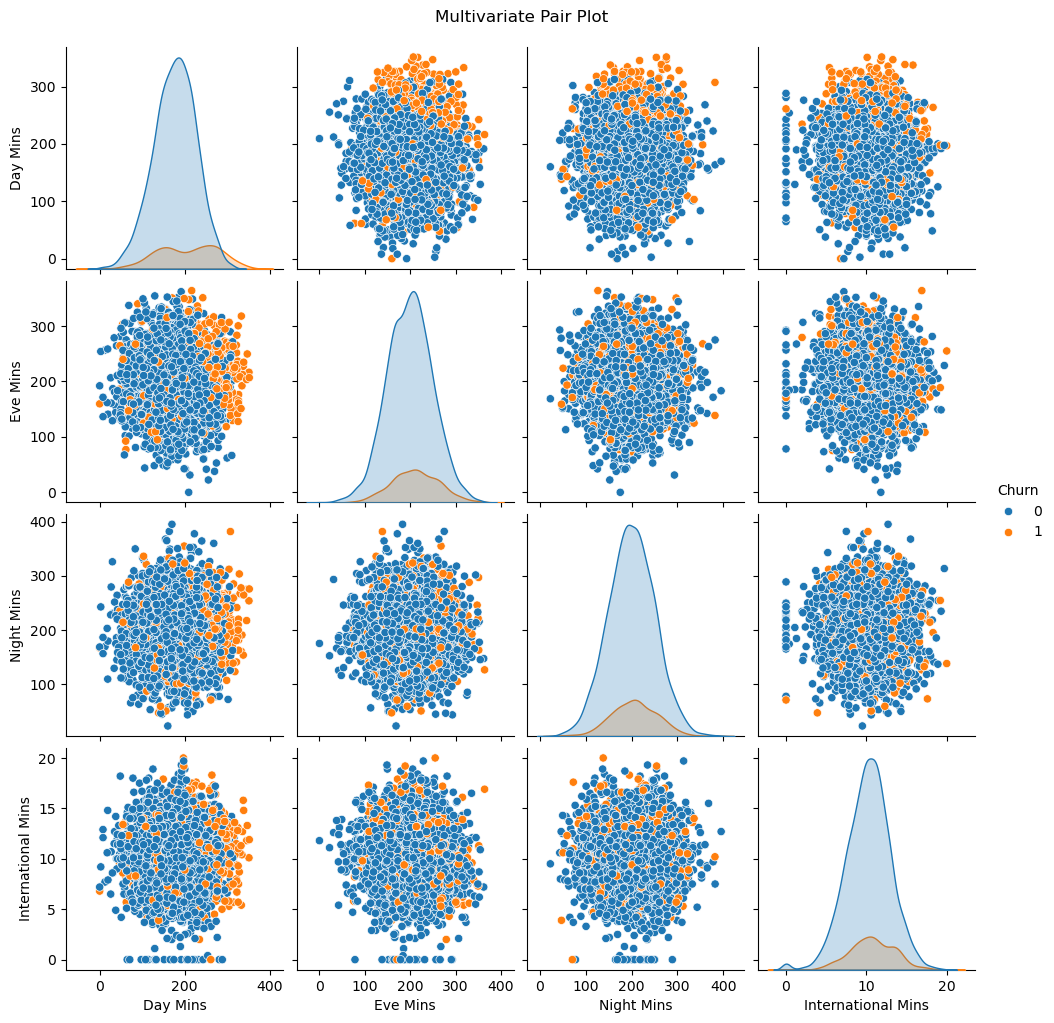

In [16]:
selected_features = ['Day Mins', 'Eve Mins', 'Night Mins', 'International Mins', 'Churn']
sns.pairplot(df[selected_features], hue='Churn')
plt.suptitle("Multivariate Pair Plot", y=1.02)
plt.show()


### D)Outlier Detection

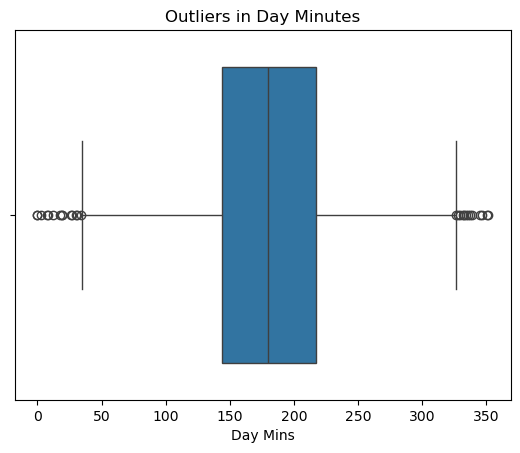

In [18]:
sns.boxplot(x='Day Mins', data=df)
plt.title("Outliers in Day Minutes")
plt.show()


In [19]:
Q1 = df['Day Mins'].quantile(0.25)
Q3 = df['Day Mins'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Day Mins'] < Q1 - 1.5*IQR) | (df['Day Mins'] > Q3 + 1.5*IQR)]
print("Outliers in Day Mins:", outliers.shape[0])


Outliers in Day Mins: 27


### E)Skewness & Distribution

Skewness: -0.0029482419465375036


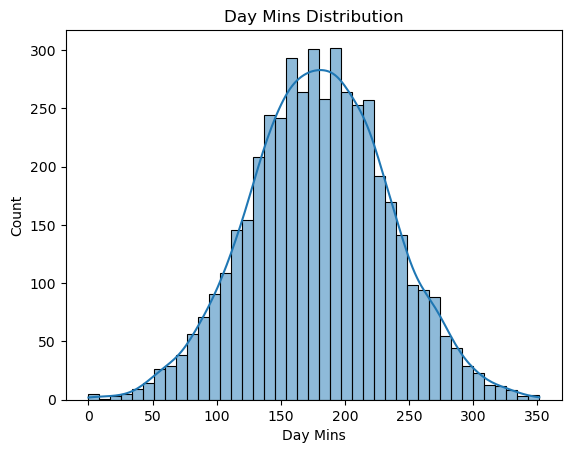

In [21]:
print("Skewness:", df['Day Mins'].skew())

sns.histplot(df['Day Mins'], kde=True)
plt.title("Day Mins Distribution")
plt.show()


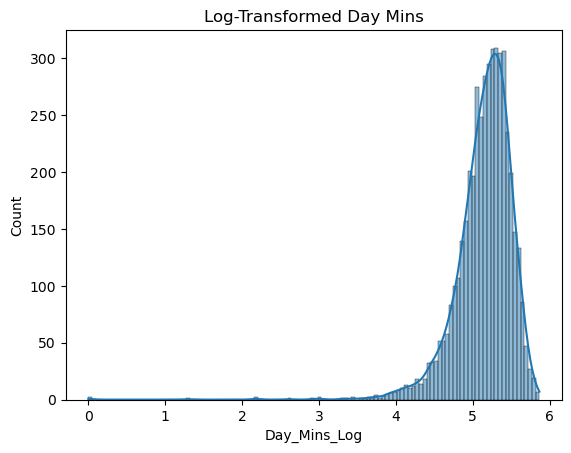

In [22]:
import numpy as np
df['Day_Mins_Log'] = np.log1p(df['Day Mins'])

sns.histplot(df['Day_Mins_Log'], kde=True)
plt.title("Log-Transformed Day Mins")
plt.show()


### F)Correlation Analysis

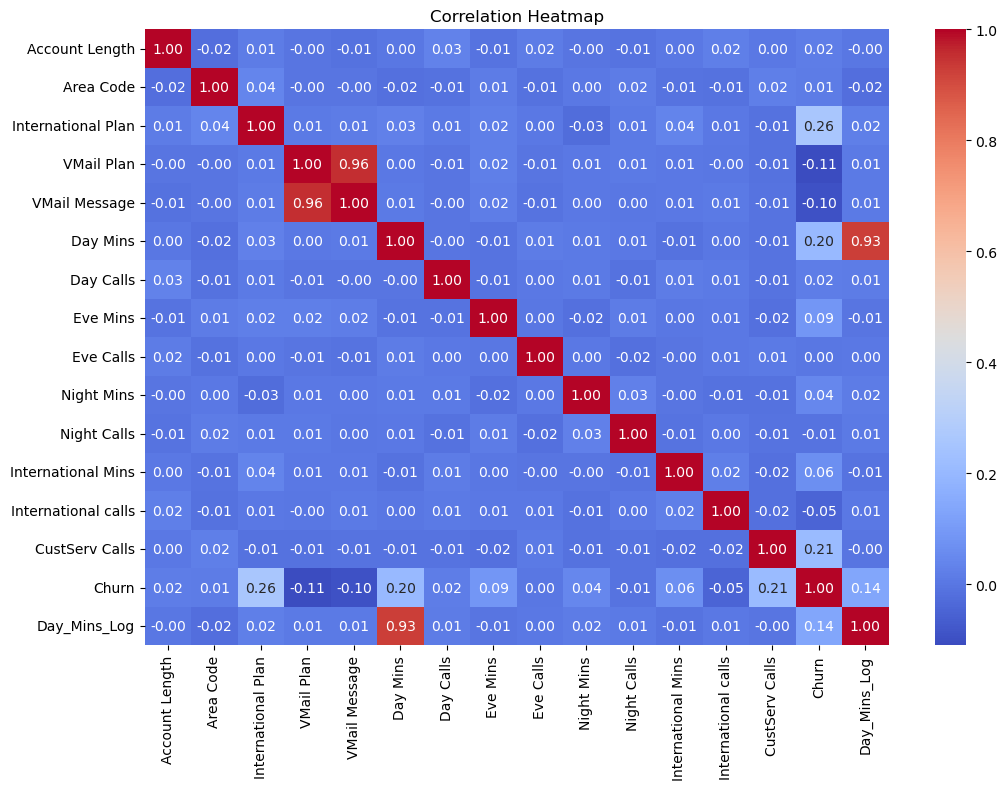

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## 5)Feature Engineering


In [26]:
df["Total Mins"] = df["Day Mins"] + df["Eve Mins"] + df["Night Mins"] + df["International Mins"]
df["Total Calls"] = df["Day Calls"] + df["Eve Calls"] + df["Night Calls"] + df["International calls"]

## 6)Train-Test Split


In [28]:
X = df.drop(["Churn", "State"], axis=1) # Drop 'State' column from features
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (3231, 17)
Testing set size: (1386, 17)


## 7)Model Building


### Logistic Regression


In [31]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Performance:\n")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1189
           1       0.56      0.25      0.35       197

    accuracy                           0.87      1386
   macro avg       0.72      0.61      0.64      1386
weighted avg       0.84      0.87      0.84      1386



### Random Forest Classifier


In [33]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance:\n")
print(classification_report(y_test, y_pred_rf))

Random Forest Performance:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1189
           1       0.96      0.77      0.85       197

    accuracy                           0.96      1386
   macro avg       0.96      0.88      0.92      1386
weighted avg       0.96      0.96      0.96      1386



### XGBoost Classifier


In [35]:
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test) # Corrected from y_test to X_test
print("XGBoost Performance:\n")
print(classification_report(y_test, y_pred_xgb))

XGBoost Performance:

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1189
           1       0.96      0.78      0.86       197

    accuracy                           0.96      1386
   macro avg       0.96      0.89      0.92      1386
weighted avg       0.96      0.96      0.96      1386



## 8)Model Evaluation


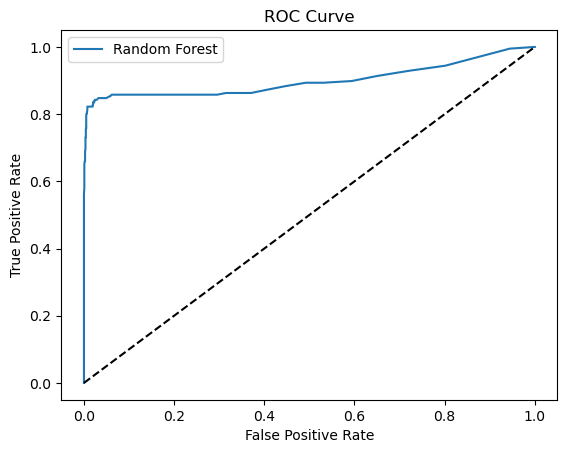

AUC Score: 0.8998454530318102


In [37]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

## 9)Churn Risk Score + CHURN-FLAG


### 9.1 Sample Predictions 

In [74]:
import plotly.express as px
threshold = 0.5  # you can tune this based on ROC curve / business needs

# Check if X_test_copy exists, if not, recreate it (assuming X_test is available)
if 'X_test_copy' not in locals() and 'X_test' in locals():
    X_test_copy = X_test.copy()
elif 'X_test_copy' not in locals() and 'X_test' not in locals():
     print("Error: X_test and X_test_copy are not defined. Please run the previous cells.")
     # You might want to add a 'raise' statement here or return from the cell
else:
    # X_test_copy already exists
    pass

X_test_copy['CHURN_FLAG'] = np.where(X_test_copy['Churn_Risk_Score'] >= threshold, 1, 0)

# Convert CHURN_FLAG to string for plotting with palette
X_test_copy['CHURN_FLAG_str'] = X_test_copy['CHURN_FLAG'].astype(str)

# Display first few predictions
print("🔎 Sample Predictions:")
display(X_test_copy[['Churn_Risk_Score', 'CHURN_FLAG']].head(10))

🔎 Sample Predictions:


,Churn_Risk_Score,CHURN_FLAG
601,79.0,1
992,5.0,1
3643,11.0,1
2213,44.0,1
309,30.0,1
553,17.5,1
2032,9.0,1
1104,3.5,1
4152,10.0,1
2335,79.0,1


### 9.2 CHURN_FLAG Distribution

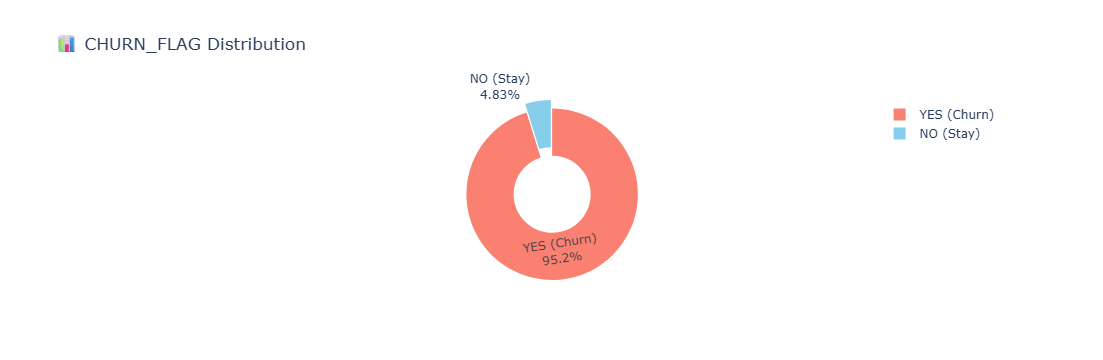

In [76]:
churn_counts = X_test_copy['CHURN_FLAG'].value_counts().reset_index()
churn_counts.columns = ['CHURN_FLAG', 'Count']
churn_counts['CHURN_FLAG'] = churn_counts['CHURN_FLAG'].map({0:'NO (Stay)', 1:'YES (Churn)'})

fig = px.pie(
    churn_counts,
    names="CHURN_FLAG",
    values="Count",
    hole=0.45,
    color="CHURN_FLAG",
    color_discrete_map={"NO (Stay)": "skyblue", "YES (Churn)": "salmon"},
    title="📊 CHURN_FLAG Distribution"
)
fig.update_traces(textinfo="percent+label", pull=[0.05, 0.05])
fig.show()

### 9.3 Distribution of Churn Risk Scores (KDE Plot)

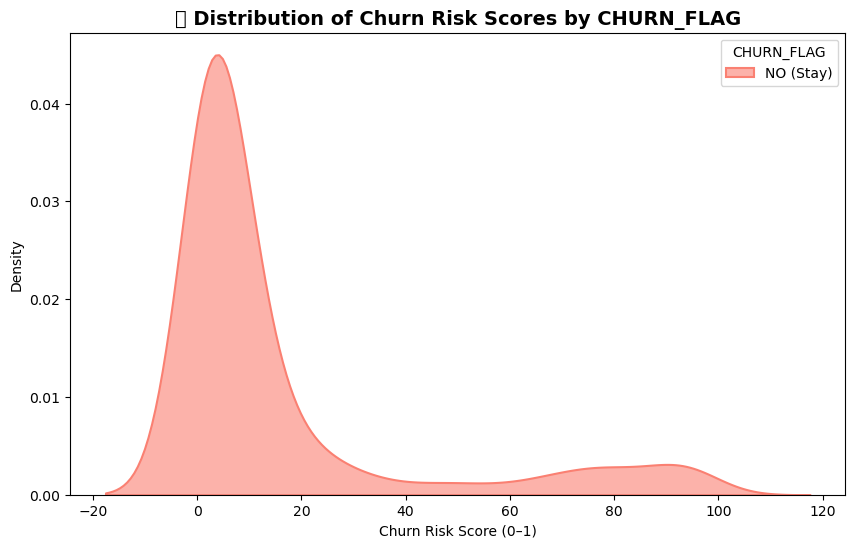

In [78]:
plt.figure(figsize=(10,6))
sns.kdeplot(
    data=X_test_copy, x='Churn_Risk_Score', hue='CHURN_FLAG',
    fill=True, common_norm=False, palette={0:"skyblue", 1:"salmon"},
    alpha=0.6, linewidth=1.5
)
plt.title("📈 Distribution of Churn Risk Scores by CHURN_FLAG", fontsize=14, fontweight='bold')
plt.xlabel("Churn Risk Score (0–1)")
plt.ylabel("Density")
plt.legend(title="CHURN_FLAG", labels=["NO (Stay)", "YES (Churn)"])
plt.show()

### 9.4 Boxplot of Churn Risk Scores

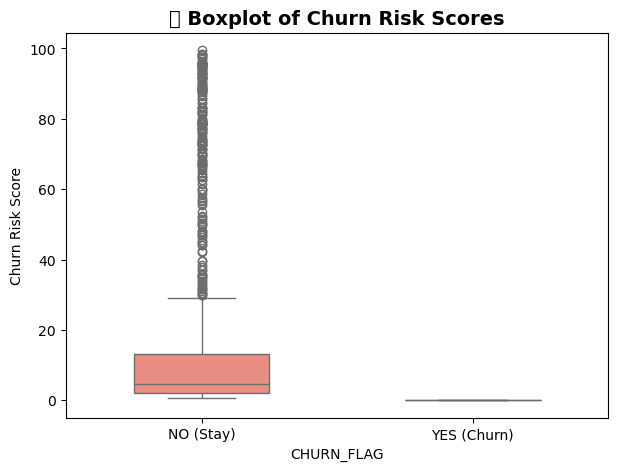

In [80]:
plt.figure(figsize=(7,5))
sns.boxplot(
    x='CHURN_FLAG_str', y='Churn_Risk_Score', data=X_test_copy,
    palette={'0':"skyblue", '1':"salmon"}, width=0.5
)
plt.xticks([0,1], ["NO (Stay)", "YES (Churn)"])
plt.title("📦 Boxplot of Churn Risk Scores", fontsize=14, fontweight='bold')
plt.xlabel("CHURN_FLAG")
plt.ylabel("Churn Risk Score")
plt.show()

### 9.5 Summary Statistics

In [84]:
summary_stats = X_test_copy.groupby('CHURN_FLAG')['Churn_Risk_Score'].agg(
    Mean='mean', Min='min', Max='max', Count='count'
).reset_index()
summary_stats['CHURN_FLAG'] = summary_stats['CHURN_FLAG'].map({0:'NO (Stay)', 1:'YES (Churn)'})

print("📌 Churn Risk Score Summary by CHURN_FLAG")
display(summary_stats)

📌 Churn Risk Score Summary by CHURN_FLAG


,CHURN_FLAG,Mean,Min,Max,Count
0,NO (Stay),0.000000,0.0,0.0,67
1,YES (Churn),15.641016,0.5,99.5,1319


### 9.6 Histogram of Churn Risk Scores

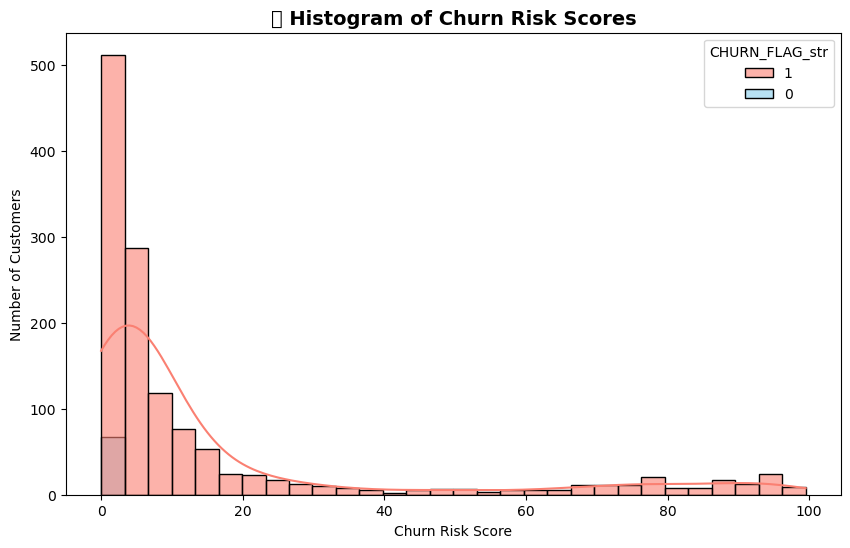

In [82]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=X_test_copy, x='Churn_Risk_Score', hue='CHURN_FLAG_str', # Use CHURN_FLAG_str for hue
    bins=30, kde=True, palette={'0':"skyblue", '1':"salmon"}, alpha=0.6 # Use string keys for palette
)
plt.title("📊 Histogram of Churn Risk Scores", fontsize=14, fontweight='bold')
plt.xlabel("Churn Risk Score")
plt.ylabel("Number of Customers")
plt.show()

## 10)Save Final Model


In [87]:
import joblib
joblib.dump(rf, "telecom_churn_model.pkl")
print("Model saved as telecom_churn_model.pkl")

Model saved as telecom_churn_model.pkl
